### Описание проекта
Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.<br>
Шаги для выбора локации обычно такие:<br>
- В избранном регионе собирают характеристики для скважин: качество нефти и объём её запасов;
- Строят модель для предсказания объёма запасов в новых скважинах;
- Выбирают скважины с самыми высокими оценками значений;
- Определяют регион с максимальной суммарной прибылью отобранных скважин.
- Вам предоставлены пробы нефти в трёх регионах. Характеристики для каждой скважины в регионе уже известны. Постройте модель для определения региона, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой Bootstrap.

### Условия задачи:
- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.
- Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

## Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from numpy.random import RandomState

Подгрузим данные и взглянем на них:

In [2]:
try:
    data_1 = pd.read_csv('geo_data_0.csv')
    data_2 = pd.read_csv('geo_data_1.csv')
    data_3 = pd.read_csv('geo_data_2.csv')
except:
    data_1 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv')
    data_2 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_1.csv')
    data_3 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_2.csv')

Чтобы не повторяться, сделаю функцию отчёт по необходимым критериям

In [3]:
def check(data, label):
    """
    Вход:
    data - датасет для анализа
    label - название
    
    Функция повторяет info, но здесь для себя столбцы с уникальными значениями и пропусками выводится
    в процентном содержании. Ну и также визуализация корреляции. 
    """
    print(label)
    res = pd.DataFrame()
    res['type'] = data.dtypes
    res['Uniq'] = data.nunique() / len(data)
    res['NaN'] = data.isna().sum() / len(data)
    print(res)
    sns.heatmap(data.corr(), annot = True, cmap = "mako")

Начнем анализ, только самое главное! 

----------------Датасет первого региона----------------
            type    Uniq  NaN
id        object  0.9999  0.0
f0       float64  1.0000  0.0
f1       float64  1.0000  0.0
f2       float64  1.0000  0.0
product  float64  1.0000  0.0


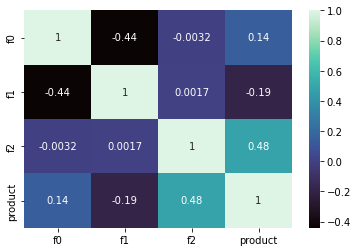

In [4]:
check(data_1, '----------------Датасет первого региона----------------')

Типы в норме, пропусков нет. <br>  
__Значения id повторяются__ - возьмём на заметку. <br> 
Нормальная отрицательная корреляция между параметрами f1 и f2 --> -0.44. <br> 
Нормальная положительная корреляция между параметрами f1 и f2 --> 0.48


----------------Датасет второго региона----------------
            type     Uniq  NaN
id        object  0.99996  0.0
f0       float64  1.00000  0.0
f1       float64  1.00000  0.0
f2       float64  1.00000  0.0
product  float64  0.00012  0.0


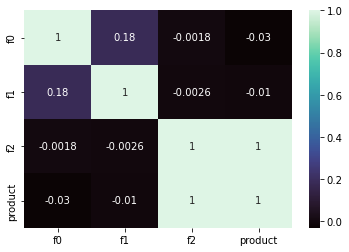

In [5]:
check(data_2, '----------------Датасет второго региона----------------')

Типы в норме, пропусков нет. <br>  
__Значения id повторяются__ - возьмём на заметку. <br> 
__Значения product__  - очень мало уникальных значений, проверим! <br> 
На корреляцию f2 и product не имеет смысла смотреть. 

----------------Датасет третьего региона----------------
            type     Uniq  NaN
id        object  0.99996  0.0
f0       float64  1.00000  0.0
f1       float64  1.00000  0.0
f2       float64  1.00000  0.0
product  float64  1.00000  0.0


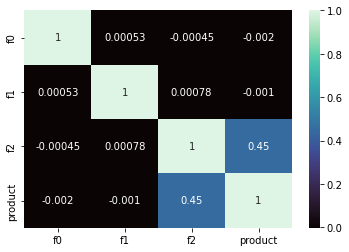

In [6]:
check(data_3, '----------------Датасет третьего региона----------------')

Типы в норме, пропусков нет. <br>  
__Значения id повторяются__ - возьмём на заметку. <br> 
Нормальная положительная корреляция между параметрами f2 и product --> 0.45

__Значения id повторяются__ проверим:

In [7]:
data_1[data_1['id'].duplicated()]

,id,f0,f1,f2,product
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
41724,bxg6G,-0.823752,0.546319,3.630479,93.007798
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205
63593,QcMuo,0.635635,-0.473422,0.862670,64.578675
66136,74z30,1.084962,-0.312358,6.990771,127.643327
69163,AGS9W,-0.933795,0.116194,-3.655896,19.230453
75715,Tdehs,0.112079,0.430296,3.218993,60.964018
90815,fiKDv,0.049883,0.841313,6.394613,137.346586
92341,TtcGQ,0.110711,1.022689,0.911381,101.318008
97785,bsk9y,0.378429,0.005837,0.160827,160.637302


In [8]:
data_1[data_1['id'] == 'HZww2']

,id,f0,f1,f2,product
931,HZww2,0.755284,0.368511,1.863211,30.681774
7530,HZww2,1.061194,-0.373969,10.430210,158.828695


Разные параметры у одинаковых id, странно, но ничего с этим делать не будем, оставим как есть. 

In [9]:
data_2.head(20)

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305
5,HHckp,-3.327590,-2.205276,3.003647,84.038886
6,h5Ujo,-11.142655,-10.133399,4.002382,110.992147
7,muH9x,4.234715,-0.001354,2.004588,53.906522
8,YiRkx,13.355129,-0.332068,4.998647,134.766305
9,jG6Gi,1.069227,-11.025667,4.997844,137.945408


Ничего странного не замечено, просто одинаковые значения. 

### Вывод

Загрузка прошла успешно. 
Замечены некоторые особенности: 
- Повторяющиеся значения id, возможно не учтен фактор времени, приборов измерения - поэтому различные значения в одной скважине. 
- Повторяющиеся значения product во втором регионе
- Есть корреляции в первом регионе между f0 и f1 - нормально отрицательная, в третьем регионе между f2 и product  - нормально положительная. 

## Построение модели для каждого региона

И так, обучим модели для каждого региона, при этом, создаем таблицу с оценкой MSE для предсказанных значений и для модели с постоянным средним. Конечно, добавим среднее значение вычисляемое моделью. 


In [10]:
dict_model = {}
score_table = pd.DataFrame()
for i, data in enumerate([data_1, data_2, data_3]):
    data = data.drop(columns = ['id'])
    x_train, x_valid, y_train, y_valid = train_test_split(data.drop(columns = ['product']),
                                                          data['product'],
                                                          test_size = 0.25,
                                                          random_state = 12345)
    lin = LinearRegression()
    lin.fit(x_train, y_train)
    score_table.loc['mean_model', 'region_' + str(i + 1)] = lin.predict(x_valid).mean()
    score_table.loc['mean_squared_error_model' , 
                    'region_' + str(i + 1)] = mean_squared_error(lin.predict(x_valid), y_valid, squared = False)
    score_table.loc['simple_mean', 'region_' + str(i + 1)] = y_train.mean()
    score_table.loc['mean_squared_error_simple_mean', 
                    'region_' + str(i + 1)] = mean_squared_error([y_train.mean() for i in range(len(y_valid))], 
                                                                         y_valid, squared = False)
    
    
    dict_model['region_' + str(i + 1) + '_valid'] = y_valid
    dict_model['region_' + str(i + 1) + '_predict'] = pd.Series(lin.predict(x_valid), index=y_valid.index)

In [11]:
score_table

,region_1,region_2,region_3
mean_model,92.592568,68.728547,94.965046
mean_squared_error_model,37.579422,0.893099,40.029709
simple_mean,92.640468,68.858955,95.038589
mean_squared_error_simple_mean,44.289591,46.021445,44.902350


Получили хорошую модель по второму региону RMSE = 0.9, почти не отличающие от константной модели по среднему получили модели по первому и третьему региону. 

В большой запас в первом и треьем регионе судя по среднему значению. 

## Подготовка к расчёту прибыли

#### Основные параметры:
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. 
- Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

In [2]:
budzet = 1e10
point_research = 500
point_best = 200
profit_one_product = 450000
risk_alpha = 0.025

<div class="alert alert-block alert-info">
    
<b>Совет:</b> Константы принято записывать в Верхнем регистре)

Вычислим, сколько должно быть минимальное количество продукта для безубыточной работы:

In [3]:
sebes_one_skv = budzet / (point_best * profit_one_product)
sebes_one_skv

111.11111111111111

Это значение превышает средние значения по регионам. Для этого следует воспользоваться нашей моделью, чтобы не прогореть. 

С тренажера возьмем функцию и скорректируем её для расчёта прибыли от продукта: 

In [14]:
def revenue(target, probabilities, count):
    """
    вход:
    target - значение целевого признака
    probabilities - предсказание
    count - количество взятых значений
    выход:
    прибыль 
    """
    probs_sorted = probabilities.sort_values(ascending=False)
    selected = target[probs_sorted.index][:count]
    return (450000 * selected.sum() - (budzet))

### Вывод
Успешно ввели переменные для будущих расчётов, а также написана функция для вычисления прибыли. 

## Расчёт прибыли

У нас три региона, следует написать функцию:

In [15]:
data_result = pd.DataFrame()
state = RandomState(12345)

def get_revenue_and_risk(name, valid, predict):
    """
    входы:
    name - наименование региона
    valid - значения целевого признака
    predict - предсказания 
    выход:
    Функция заполняет датафрем для региона, проводя bootstrap, вычисляет прибыль.
    Вычисляется среднее значение
                нижняя граница 95% интервала
                верхняя граница 95% интервала
                стандартное отклонение
                риск
    """
    revenues_lst = []
    for i in range(1000):
        target_subsample = valid.sample(n=point_research, replace=True, random_state=state)
        probs_subsample = predict[target_subsample.index]
        revenues_lst.append(revenue(target_subsample, probs_subsample, point_best))
    revenues = pd.Series(revenues_lst)
    data_result.loc[name, 'revenues_mean'] = revenues.mean() / 1e6
    lower = revenues.quantile(0.025) / 1e6
    data_result.loc[name, 'revenues_lower'] = lower
    upper = revenues.quantile(0.975) / 1e6
    data_result.loc[name, 'revenues_upper'] = upper
    data_result.loc[name, 'std'] = revenues.std() / 1e6
    data_result.loc[name, 'risk_of_loss'] = (revenues < 0).sum() / revenues.count() * 100
    data_result.loc[name, 'risk_must'] = risk_alpha
    

Запустим нашу функцию по регионам:

In [16]:
for i in range(0, 3):
    get_revenue_and_risk('region_' + str(i + 1),
                         dict_model['region_' + str(i + 1) + '_valid'],
                         dict_model['region_' + str(i + 1) + '_predict'])

Для принятия решения хочу свести в таблицу дополнительный параметр - качество модели, вычислю его как отношения средней квадратичной ошибки от нашей модели к констанстной модели с постоянным средним значением. 

In [17]:
data_result['model_fact'] = score_table.T['mean_squared_error_model'] / score_table.T['mean_squared_error_simple_mean']

In [18]:
columns_up = ['revenues_mean', 'revenues_lower', 'revenues_upper']
columns_down = ['risk_of_loss', 'model_fact', 'std']
(
data_result.style.highlight_max(color='yellowgreen', subset=columns_up)
                 .highlight_min(color='yellowgreen', subset=columns_down)
)

,revenues_mean,revenues_lower,revenues_upper,std,risk_of_loss,risk_must,model_fact
region_1,425.938527,-102.090095,947.976353,277.276722,6.000000,0.025000,0.848493
region_2,518.259494,128.123231,953.612982,209.647539,0.300000,0.025000,0.019406
region_3,420.194005,-115.852609,989.629940,284.673132,6.200000,0.025000,0.891484


И так мы получили сводную таблицу, зеленым подсвечены, интересующие нас параметры. 

Очевидно отсеиваются первый и третий регионы, они не проходят по уровню риска менее 2.5%.

Второй регион также выигрывает в средней прибыли, имеет положительную нижнюю границу доверительного интревала, и хорошее качество модели относительно других регионов. 

### Итоговый вывод


Мы готовили ответ на вопрос: в какой регион идти? Ответим же:
- Критерием выбора, были два основных параметра: риск и средняя прибыль. Мы выделили параметры наилучшие параметры и они оказались на одной строке - второй регион, имея **0.3% риска**, и наибольшую среднюю прибыль среди рассматриваемых регионов в **518.2 млн.руб**, что почти **в 5 раз больше** безубыточной работы, вычисленной нами : **111.11 млн.руб.**

Стоит отметить, для дальнейшего изучения:

- Повторяющиеся значения id, возможно не учтен фактор времени, приборов измерения - поэтому различные значения в одной скважине. 
- Качество моделей 1 и 3 региона на ~90% схожи с константной моделью. 
- Повторяющие значение продукта во втором регионе. 
